In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('complaintsdata.csv')

In [3]:
df['category'] = df['l2']

In [4]:
df.head()

,id,text,l1,l2,category
0,2.263110e+16,@FC_HELP can I return online purchases to a Ho...,0,apparel,apparel
1,2.336410e+16,@FC_Help Hi - I'm writing a piece for MSN Him ...,0,apparel,apparel
2,2.555040e+16,@FC_Help i need to check my order,0,apparel,apparel
3,2.949500e+16,@FC_Help I need to get in contact with someone...,1,apparel,apparel
4,3.252370e+16,@FC_Help How can I get a hold of you so we can...,0,apparel,apparel


In [5]:
df['category'].unique()

array(['apparel', 'electronics', 'other', 'food', 'software', 'cars',
       'retail', 'services', 'random_tweet', 'random_reply', 'transport'],
      dtype=object)

In [6]:
df.groupby(['category']).size()

category
apparel         262
cars             93
electronics     290
food            128
other           128
random_reply    739
random_tweet    736
retail          198
services        336
software        292
transport       247
dtype: int64

<AxesSubplot: xlabel='category'>

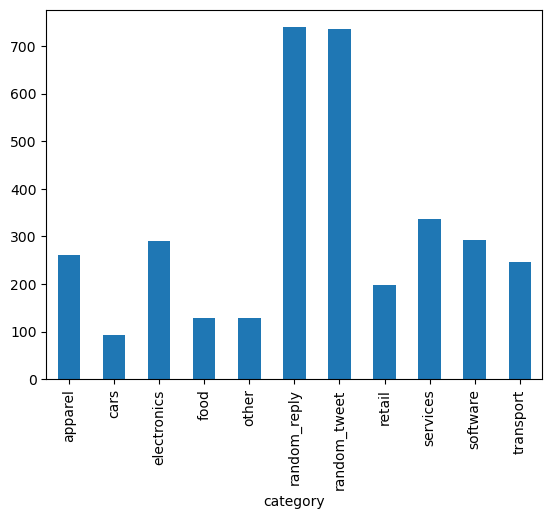

In [7]:
df.groupby(['category']).size().plot.bar()

# Preprocessing Data

In [8]:
# pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [9]:

from transformers import BertTokenizer

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [11]:
example_text = 'I will watch Memento tonight'

In [12]:
bert_input = tokenizer(example_text,
                       padding='max_length',
                       max_length=10,
                       truncation=True,
                       return_tensors="pt")

In [13]:
print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [14]:
# We can actually decode these input ids into the actual tokens as:
tokenizer.decode(bert_input.input_ids[0])

'[CLS] I will watch Memento tonight [SEP] [PAD] [PAD]'

# Dataset Class

In [15]:
import torch

In [16]:
import numpy as np

In [17]:
from transformers import BertTokenizer

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'apparel':0, 'electronics':1, 'other':2, 'food':3, 'software':4, 'cars':5,
       'retail':6, 'services':7, 'random_tweet':8, 'random_reply':9, 'transport':10}

In [19]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length',
                                max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [20]:
# let’s split our dataframe into training, validation, and test set - 8:1:1


np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

2759 345 345


In [22]:
test = Dataset(df_test)

In [23]:
torch.utils.data.DataLoader(test, batch_size=2)

In [24]:
test

# Model Building

In [22]:
from torch import nn
from transformers import BertModel

In [23]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

# training the model

In [24]:
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 1
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 2/1380 [00:06<1:07:37,  2.94s/it]

# Evaluate Model on Test Data

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)